# Softmax exercise


- (1) 소프트맥스 분류기의 완전히 벡터화된 손실 함수를 실행해보자.
- (2) 그것의 분석적 그래디언트의 완전 벡터화 표현을 실행해보자.
- (3) 수치적 그래디언트 방법으로 위의 수행을 확인해보자.
- (4) 학습률lr과 정규화 인자reg를 조정하여 검증 집합을 이용해보자.
- (5) SGD로 손실 함수를 최적화해보자.
- (6) 최종적인 학습된 가중치를 시각화해보자. 

### 0. Load

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    디스크에서 CIFAR-10 데이터셋을 불러오고, 이것을 선형 분류하기 위해 전처리를 수행한다. 이것은 SVM에서와 동일한
    과정이지만, 그것과 다르게 단일 함수로 압축된다. 
    """
    # raw CIFAR-10 data 불러오기
    cifar10_dir = '/Users/jeongjaeyeong/cifar-10-batches-py'
    
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # the data 부표본화 하기.
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # 전처리 과정: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # 데이터 표본화 하기: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # bias 차원 더하고, 열로 변형시켜라. 
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


#### 행렬 계산에 대한 시각화
![tt](softmax_1_derivativation_picture.png)<br>
cf.http://intelligence.korea.ac.kr/jupyter/2020/06/30/softmax-classifer-cs231n.html

##### 수식으로 표현하는 미분 과정<br><br> 

![deriva_formulas](softmax_loss_derivativation_formulas.JPG)

### 1. Loop를 이용한 softmax

In [29]:


from cs231n.classifiers.softmax import softmax_loss_naive
import time
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange


def softmax_loss_naive(W, X, y, reg):

    loss = 0.0
    dW = np.zeros_like(W) # (3073, 10)

    num_class=W.shape[1] # W(3073, 10) --> 10
    num_train=X.shape[0] # X_dev(500, 3073) --> 500
    
    
    
    for i in range(num_train): #클래스 당 훈련 자료 수 만큼 loop
        
        
        scores = np.dot(X[i],W) # (500, 10) s=WX + b
        scores = scores - np.max(scores) # blowup 방지하기 위해
        
        e_si = np.exp(scores) # e^{si}
        sum_e_sj = np.sum(e_si) #sum_{j=1}^n e^sj
        
        probability = e_si/sum_e_sj #확률, 소프트맥스 함수의 output; (500, 10) / (500, 1) = (500, 10)
        
        #loss 업데이트 for each y[i]
        
        loss -= np.log(probability[y[i]]) # 정답 클래스 스코어에 해당하는 부분의 손실을 빼준다
        
        #dW 업데이트
        
        for j in range(num_class):
            
            if i == j:
                
                dW[:,y[j]] = X[i]*(-1+probability[y[j]]) # X[i]는 ds/dw에 대한 미분값
                                                         #dW 는 dLi/dW
            else:
                
                dW[:,j] = X[i]*probability[j]
                
        
        
        # Regularization
    dW /= num_train
    dW += reg*W
    loss /= num_train
    loss += 0.5*reg * np.sum(W * W)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

# 랜덤 소프트맥스 가중치 행렬을 만들고, 손실을 계산하는데 사용하기

W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))


loss: 2.324738
sanity check: 2.302585


### 2.벡터화를 이용한 softmax 분류

In [85]:
# 우리는 이제까지 소프트맥스 손실 함수와 그것의 그래디언트에 대한 naive 수행을 해보았다. 이번에는 벡터화 버젼을 수행해보자.
# 두 버젼은 동일한 결과가 나와야 한다. 하지만 벡터화 버젼이 더 빨라야 한다.

def softmax_loss_vectorized(W, X, y, reg):
   
    loss = 0.0
    dW = np.zeros_like(W)

    num_class=W.shape[1] # W(3073, 10) --> 10
    num_train=X.shape[0] # X_dev(500, 3073) --> 500

    scores=X.dot(W) #(500, 10)
    scores = scores - np.max(scores, axis= -1, keepdims=True) # blowup 방지
                                                              # 모든 행에 대하여, 각 행의 max 값을 그 행의 모든 수를 빼준다
    exp_scores = np.exp(scores)
    sum_exp_scores = np.sum(exp_scores,axis=-1, keepdims=True) # 행렬을 벡터로 변환 500, 1 
                                                               # 각 행에 있는 모든 수를 더하여, 500, 1의 열벡터로 만든다.
    probability = exp_scores/sum_exp_scores # 500, 10 / 500, 1 = 500, 10
    
    pi = probability[np.arange(num_train),y] #정답 클래스 스코어의 열column만을 추출 (500, 1)
    
# loss 업데이트
    
    loss = np.sum(-np.log(pi)) # 정답 클래스 스코어에 해당하는 부분의 손실을 빼준다
    
    #dW 업데이트
    
    pi -= 1 # 정답 클래스 스코어 위치에 있는 가중치를 1 만큼 빼준다
    dW += np.dot(X.T, probability) # (3073, 500) * (500, 10) = (3073, 10)
    
    # 정규화
    
    loss /= num_train
    dW /= num_train
    
    loss += 0.5*reg*np.sum(W*W)
    dW += reg*W


    return loss, dW

loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

   
   

loss: 2.324738
sanity check: 2.302585


In [86]:
print('\n','\n','\n')
print('수치적 그래디언트와 분석적 그래디언트 간의 차이를 비교해보자.\n')


# 소프트맥스_손실_naive를 수행해보고, 중첩 루프를 사용한 그래디언트를 수행해보라.

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

#SVM 때처럼, 디버깅 도구인 "수치적numeric 그래디언트" 체크를 해보라
#수치적 그래디언트는 분석적 그래디언트와 거의 동일해야 한다.

from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 정규화를 포함한 그래디언트 체크도 해보자.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


print('\n','\n','\n')

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('(1) naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('(2) vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('(3) Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('(4) Gradient difference: %f' % grad_difference)

if loss_naive > loss_vectorized:
    print('\n',"====> 벡터화 버젼이 더 빠르다!")


 
 

수치적 그래디언트와 분석적 그래디언트 간의 차이를 비교해보자.

numerical: -1.427720 analytic: -0.000758, relative error: 9.989383e-01
수치적 그래디언트와 분석적 그래디언트 간의 차이: 1.426961


numerical: -1.013161 analytic: -0.000991, relative error: 9.980457e-01
수치적 그래디언트와 분석적 그래디언트 간의 차이: 1.012170


numerical: -0.017838 analytic: 0.006233, relative error: 1.000000e+00
수치적 그래디언트와 분석적 그래디언트 간의 차이: 0.024071


numerical: -1.337352 analytic: 0.008258, relative error: 1.000000e+00
수치적 그래디언트와 분석적 그래디언트 간의 차이: 1.345610


numerical: -0.211714 analytic: -0.005472, relative error: 9.496083e-01
수치적 그래디언트와 분석적 그래디언트 간의 차이: 0.206241


numerical: 4.434354 analytic: 0.010657, relative error: 9.952049e-01
수치적 그래디언트와 분석적 그래디언트 간의 차이: 4.423697


numerical: -0.929534 analytic: 0.005161, relative error: 1.000000e+00
수치적 그래디언트와 분석적 그래디언트 간의 차이: 0.934694


numerical: 1.040891 analytic: 0.007585, relative error: 9.855316e-01
수치적 그래디언트와 분석적 그래디언트 간의 차이: 1.033306


numerical: 1.323125 analytic: 0.008033, relative error: 9.879307e-01
수치적 그래디언트와 분석적 그

### 3. 검증 집합으로 매개변수를 조정해보자. (0.35 이상의 정확도를 얻어야 한다)

In [70]:

# 패러미터를 조정하기 위해 검증 set을 사용하라. 당신은 각각 다른 패러미터(학습률, 정규화 strengths)를 갖고 실험해야 한다.
# 만약 당신이 주의해서 수행한다면, 검증 set에 대해 0.35 이상의 분류 정확성을 얻을 수 있다.

from cs231n.classifiers import Softmax
import time
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################


# 다음의 수치들을 제공했다. 이 매개변수를 바꿀지 여부는 당신의 선택에 달려있다.

learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

tic = time.time()

for num_iters in [500,1000,1500]:
    for lr in learning_rates:
        for reg in regularization_strengths:
            softmax_machine = Softmax()
            softmax_machine.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=num_iters, batch_size=200, verbose=False)
        
            y_train_predict = softmax_machine.predict(X_train)
            y_val_predict = softmax_machine.predict(X_val)
        
            train_accuracy = sum(y_train_predict == y_train)/len(y_val)
            val_accuracy = sum(y_val_predict == y_val)/len(y_val)
        
            results[(lr, reg)] = (train_accuracy, val_accuracy)
            
            if(best_val < val_accuracy):
                best_val = val_accuracy
                best_softmax = softmax_machine
        

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e 트레이닝 집합 정확도: %f 검증 집합 정확도: %f' % (
                lr, reg, train_accuracy, val_accuracy))
toc= time.time()
print('교차검증 동안 얻은 최고의 검증 정확도: %f' % best_val)
print('수행 소요 시간: %fsec' % (toc-tic))


lr 1.000000e-07 reg 2.500000e+04 트레이닝 집합 정확도: 17.286000 검증 집합 정확도: 0.371000
lr 1.000000e-07 reg 5.000000e+04 트레이닝 집합 정확도: 16.212000 검증 집합 정확도: 0.347000
lr 5.000000e-07 reg 2.500000e+04 트레이닝 집합 정확도: 17.004000 검증 집합 정확도: 0.355000
lr 5.000000e-07 reg 5.000000e+04 트레이닝 집합 정확도: 16.209000 검증 집합 정확도: 0.342000
교차검증 동안 얻은 최고의 검증 정확도: 0.371000
수행 소요 시간: 34.309569sec


### 4. 테스트 셋에 best 모델을 평가해보자

In [68]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


### 5. 시각화

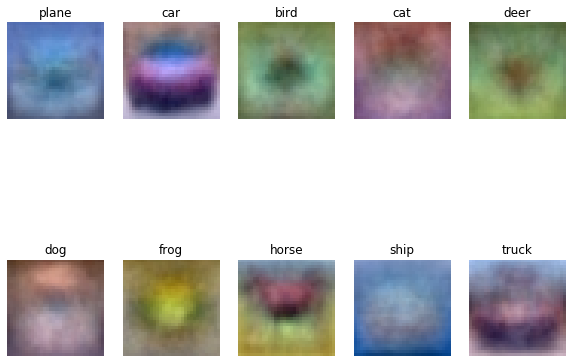

In [71]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])